In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

ABOUT DATASET
1. Age : Hastanın yaşı.  
2. Sex : Hastanın cinsiyeti.  
3. exng (exercise induced angina) : Egzersiz sırasında anjina olup olmadığı (1 = evet, 0 = hayır).  
4. caa (number of major vessels colored by fluoroscopy): Büyük damarların sayısı (0-3 arasında değişir).  
5. cp (chest pain type) : Göğüs ağrısı türü;  
   - 1: Tipik anjina  
   - 2: Atipik anjina  
   - 3: Non-anjinal ağrı  
   - 4: Asemptomatik  
6. trtbps (resting blood pressure): İstirahat halindeki kan basıncı (mm Hg cinsinden).  
7. chol (cholesterol) : BMI sensörü aracılığıyla ölçülen kolesterol seviyesi (mg/dL cinsinden).  
8. fbs (fasting blood sugar) : Açlık kan şekeri > 120 mg/dL olup olmadığı (1 = doğru, 0 = yanlış).  
9. restecg (resting electrocardiographic results) : İstirahat Elektrokardiyografi Sonuçları;  
   - 0: Normal  
   - 1: ST-T dalga anormalliği (T dalga inversiyonları ve/veya ST yükselmesi veya depresyonu > 0.05 mV)  
   - 2: Estes kriterine göre muhtemel veya kesin sol ventrikül hipertrofisi  
10. thalachh (maximum heart rate achieved) : Hastanın ulaştığı maksimum kalp atış hızı.  
11. oldpeak (ST depression induced by exercise): Egzersiz sırasında dinlenmeye kıyasla ST depresyonu (float).  
12. slp (slope of the peak exercise ST segment): Egzersiz sırasındaki ST segmentinin eğimi.  
13. thall (thalassemia): Talasemi türü;  
   - 0: Eksik veri  
   - 1: Normal  
   - 2: Sabit kusur  
   - 3: Tersine çevrilebilir kusur  
14. output :  
   - 0 = Daha az kalp krizi riski  
   - 1 = Daha yüksek kalp krizi riski  

In [4]:
def load_data():
    data =pd.read_csv(r"heart.csv")
    return data
df = load_data()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
#missing value
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [8]:
#Categorical,cardinal and numerical analysis
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 303
Variables: 14
cat_cols: 9
num_cols: 5
cat_but_car: 0
num_but_cat: 9


In [9]:
cat_cols

['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']

In [10]:
num_cols

['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

     sex      Ratio
sex                
1    207  68.316832
0     96  31.683168


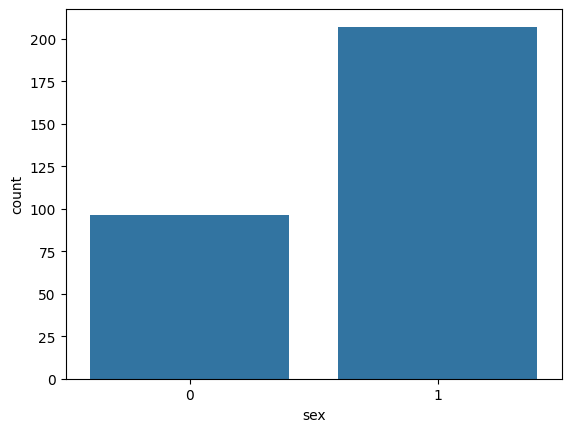

##########################################
     cp      Ratio
cp                
0   143  47.194719
2    87  28.712871
1    50  16.501650
3    23   7.590759


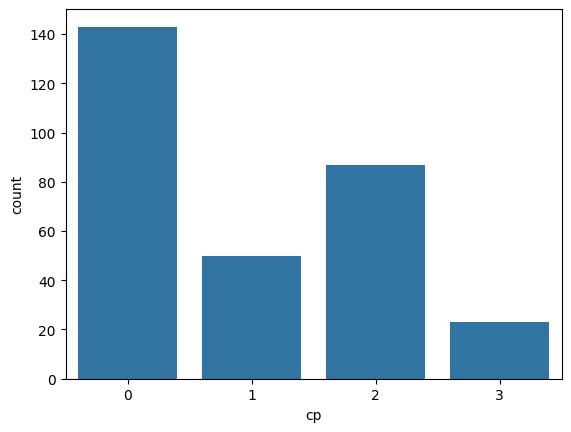

##########################################
     fbs      Ratio
fbs                
0    258  85.148515
1     45  14.851485


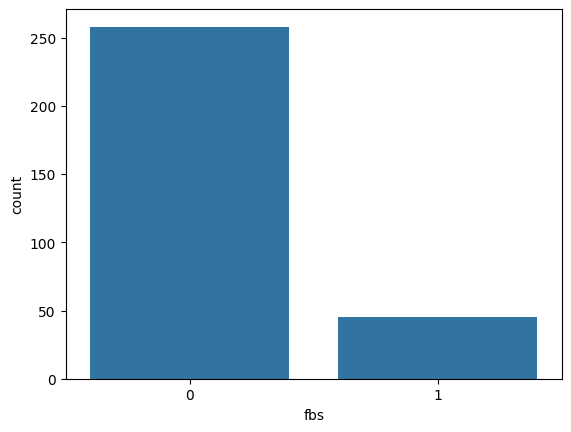

##########################################
         restecg      Ratio
restecg                    
1            152  50.165017
0            147  48.514851
2              4   1.320132


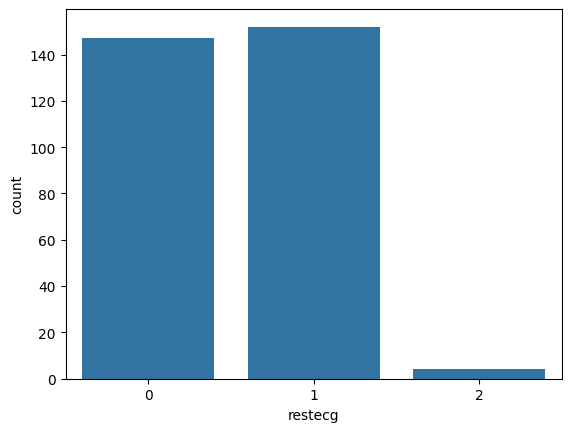

##########################################
      exng      Ratio
exng                 
0      204  67.326733
1       99  32.673267


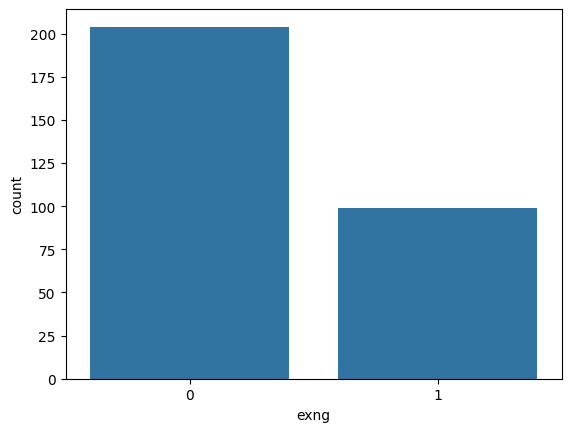

##########################################
     slp      Ratio
slp                
2    142  46.864686
1    140  46.204620
0     21   6.930693


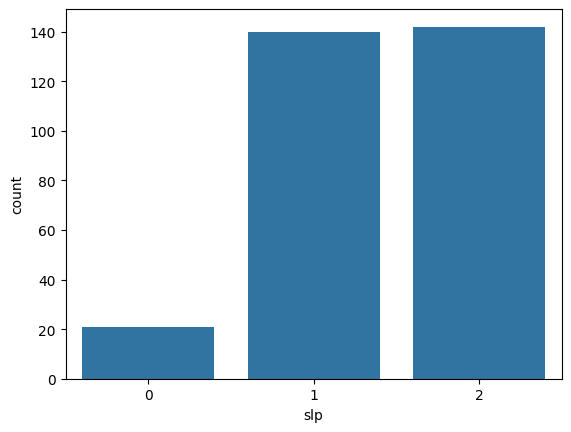

##########################################
     caa      Ratio
caa                
0    175  57.755776
1     65  21.452145
2     38  12.541254
3     20   6.600660
4      5   1.650165


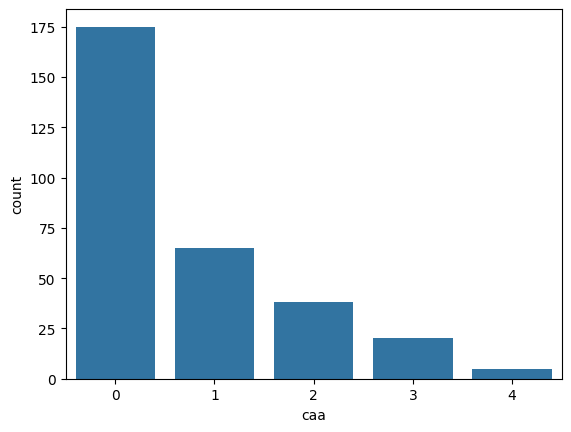

##########################################
       thall      Ratio
thall                  
2        166  54.785479
3        117  38.613861
1         18   5.940594
0          2   0.660066


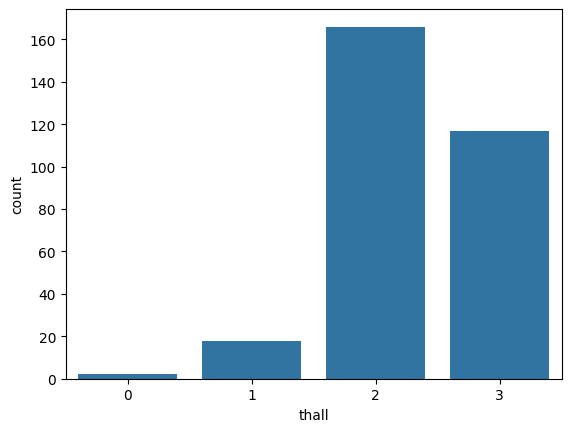

##########################################
        output      Ratio
output                   
1          165  54.455446
0          138  45.544554


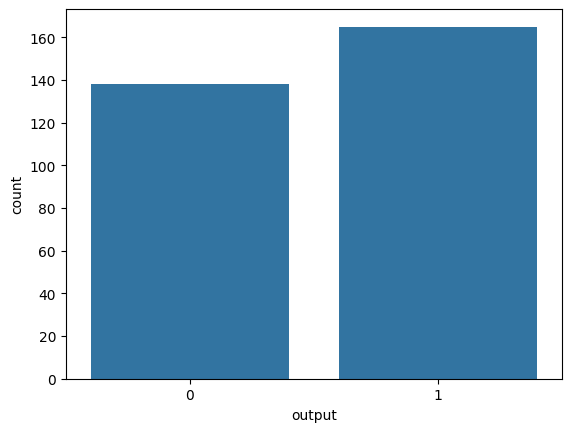

##########################################


In [11]:
#categorical analysis
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
   
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
    print("##########################################")
    
for col in cat_cols:
    cat_summary(df, col,True)

In [12]:
# Select numerical variables and the "output" variable
df_numerical = df.loc[:,num_cols + ["output"]]
df_numerical

,age,trtbps,chol,thalachh,oldpeak,output
0,63,145,233,150,2.3,1
1,37,130,250,187,3.5,1
2,41,130,204,172,1.4,1
3,56,120,236,178,0.8,1
4,57,120,354,163,0.6,1
...,...,...,...,...,...,...
298,57,140,241,123,0.2,0
299,45,110,264,132,1.2,0
300,68,144,193,141,3.4,0
301,57,130,131,115,1.2,0


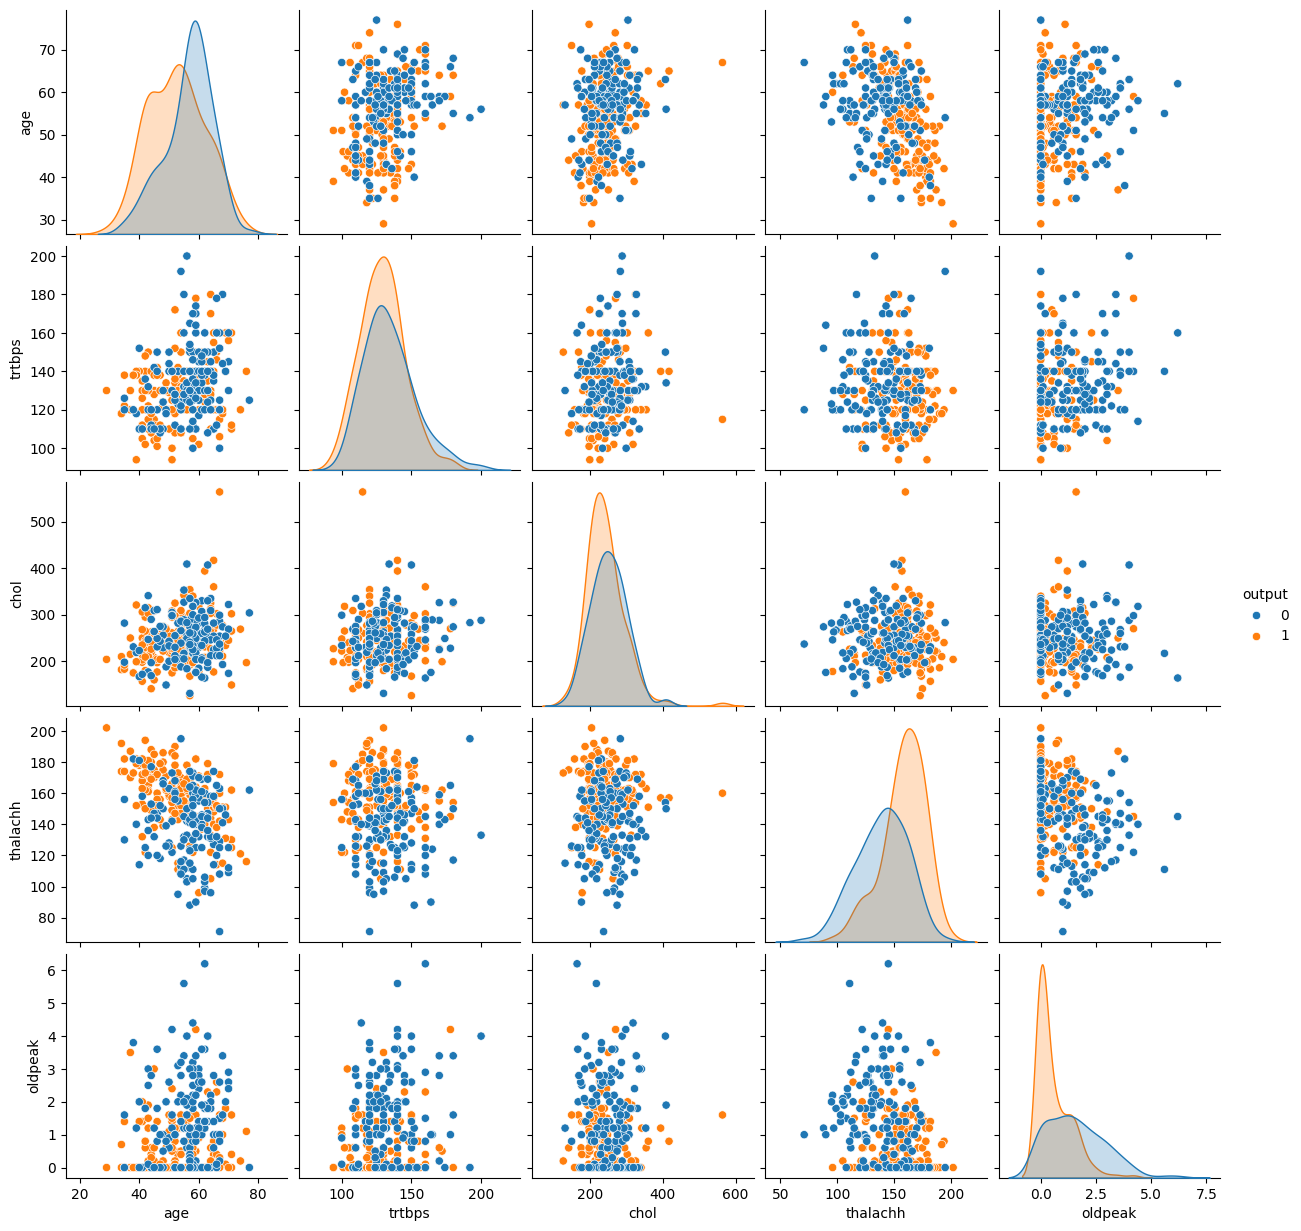

In [13]:
# Create a pairplot to visualize relationships between variables
sns.pairplot(df_numerical, 
             hue = "output", # Color the data points based on the "output" variable
             diag_kind = "kde") # Use KDE (Kernel Density Estimation) for diagonal plots

In [14]:
#standart scaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[num_cols])

df_dummy = pd.DataFrame(scaled_array, columns = num_cols)
df_dummy = pd.concat([df_dummy, df.loc[:,"output"]] , axis = 1)

<Axes: xlabel='features', ylabel='value'>

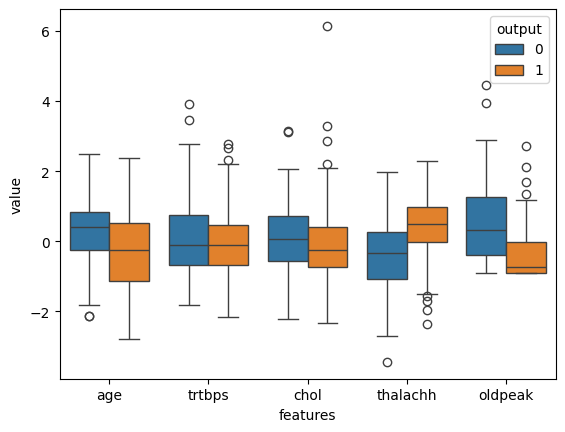

In [15]:
#box plot
data_melted = pd.melt(df_dummy, id_vars = "output", var_name = "features", value_name = "value")
plt.figure()
sns.boxplot(x = "features", y = "value", hue = "output", data = data_melted)

<Axes: xlabel='features', ylabel='value'>

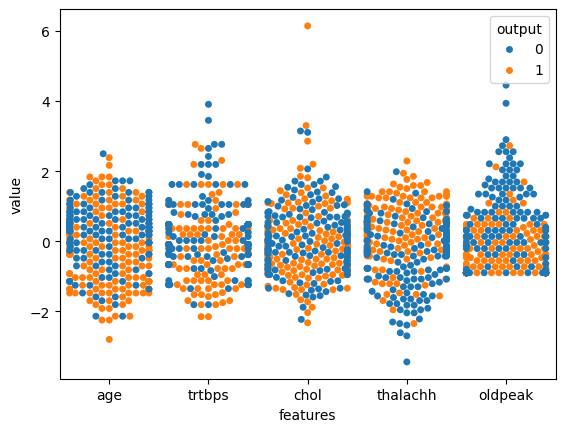

In [16]:
#swarm plot
plt.figure()
sns.swarmplot(x = "features", y = "value", hue = "output", data = data_melted)

Text(0.5, 1.0, 'Correlation Matrix')

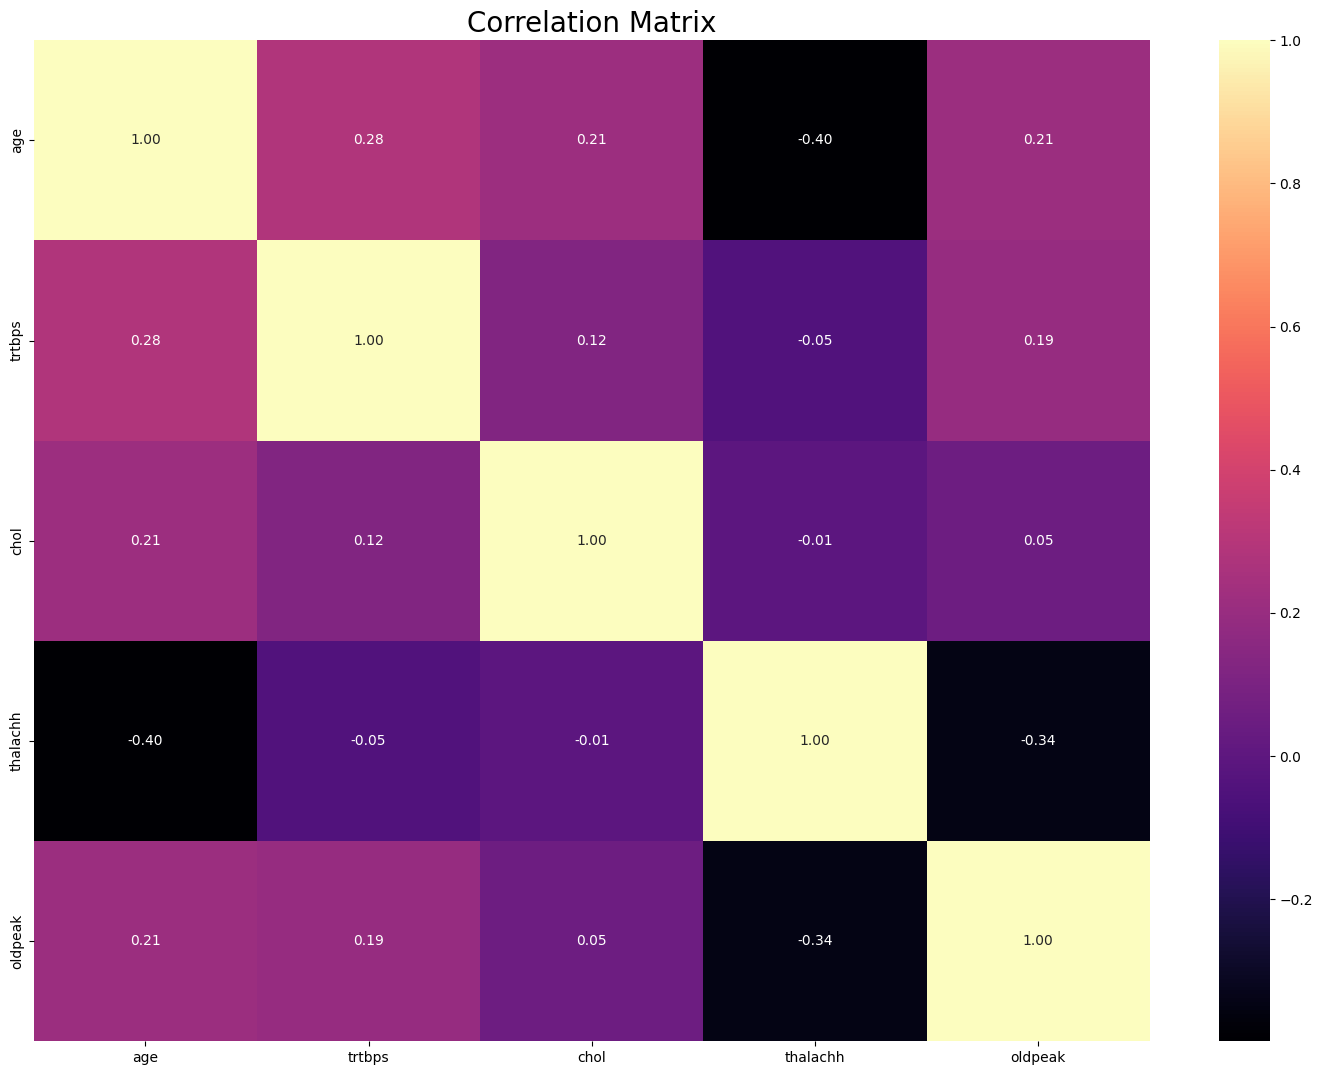

In [17]:
# Plot the heatmap of the correlation matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(),# - df[num_cols].corr() computes the correlation matrix for numerical columns
            annot=True, # - annot=True displays the correlation values inside the heatmap
            fmt=".2f", # - fmt=".2f" ensures values are shown with two decimal places
            ax=ax, cmap="magma")  # - cmap="magma" sets the color scheme of the heatmap
ax.set_title("Correlation Matrix", fontsize=20)

In [18]:
df.corrwith(df["output"]).sort_values(ascending=False)

output      1.000000
cp          0.433798
thalachh    0.421741
slp         0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trtbps     -0.144931
age        -0.225439
sex        -0.280937
thall      -0.344029
caa        -0.391724
oldpeak    -0.430696
exng       -0.436757
dtype: float64

In [19]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [20]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(check_outlier(df,col))  

False
False
True
False
False


In [21]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    # Ensure the variable is of float type before replacing values
    dataframe[variable] = dataframe[variable].astype(float)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
# replace with up or low limit
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

age False
trtbps False
chol True
thalachh False
oldpeak False


In [23]:
df1 = df.copy()

#categorical to numeric one hot encoding
df1 = pd.get_dummies(df1, columns = cat_cols[:-1],drop_first = True)

X = df1.drop(["output"], axis = 1)
y = df1[["output"]]

In [24]:
#scaling 
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


In [25]:
X[num_cols]

,age,trtbps,chol,thalachh,oldpeak
0,0.952197,0.763956,-0.256662,0.015443,1.087338
1,-1.915313,-0.092738,0.073051,1.633471,2.122573
2,-1.474158,-0.092738,-0.819112,0.977514,0.310912
3,0.180175,-0.663867,-0.198477,1.239897,-0.206705
4,0.290464,-0.663867,2.090115,0.583939,-0.379244
...,...,...,...,...,...
298,0.290464,0.478391,-0.101503,-1.165281,-0.724323
299,-1.033002,-1.234996,0.344579,-0.771706,0.138373
300,1.503641,0.706843,-1.032456,-0.378132,2.036303
301,0.290464,-0.092738,-2.234936,-1.515125,0.138373


In [26]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_prob = logreg.predict_proba(X_test)

In [28]:
y_pred_prob[:50]

array([[0.97398994, 0.02601006],
       [0.54475623, 0.45524377],
       [0.35381194, 0.64618806],
       [0.9765418 , 0.0234582 ],
       [0.06156258, 0.93843742],
       [0.0777052 , 0.9222948 ],
       [0.35329201, 0.64670799],
       [0.99430529, 0.00569471],
       [0.98722673, 0.01277327],
       [0.4287955 , 0.5712045 ],
       [0.45172827, 0.54827173],
       [0.89432102, 0.10567898],
       [0.07780389, 0.92219611],
       [0.94799418, 0.05200582],
       [0.01526759, 0.98473241],
       [0.04871886, 0.95128114],
       [0.02262081, 0.97737919],
       [0.96040129, 0.03959871],
       [0.99281784, 0.00718216],
       [0.98573893, 0.01426107],
       [0.57133021, 0.42866979],
       [0.92532602, 0.07467398],
       [0.63978466, 0.36021534],
       [0.25043171, 0.74956829],
       [0.17751282, 0.82248718],
       [0.376279  , 0.623721  ],
       [0.12561133, 0.87438867],
       [0.28748219, 0.71251781],
       [0.95723415, 0.04276585],
       [0.04625204, 0.95374796],
       [0.

In [29]:
y_pred = np.argmax(y_pred_prob, axis =1)
y_pred

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [30]:
print(f"test accuracy: {accuracy_score(y_test,y_pred)}")

test accuracy: 0.9016393442622951


Text(0.5, 1.0, 'Logistic Regression ROC Curve')

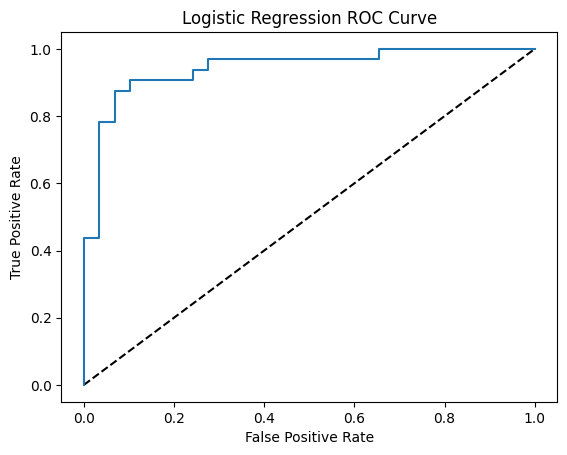

In [31]:
#roc curve
# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and threshold values  
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:, 1])  # Using the predicted probabilities for the positive class  

# Plot the diagonal reference line (random classifier performance)
plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal line represents a random model (AUC = 0.5)  

# Plot the actual ROC curve for the Logistic Regression model  
plt.plot(fpr, tpr, label="Logistic Regression")  

# Label the x-axis and y-axis  
plt.xlabel("False Positive Rate")  # Proportion of actual negatives incorrectly classified as positives  
plt.ylabel("True Positive Rate")   # Proportion of actual positives correctly classified  

plt.title("Logistic Regression ROC Curve")

In [32]:
#hyperparameter tuning
lr = LogisticRegression(solver="liblinear")  # l1'i destekleyen solver
penalty = ["l1", "l2"]
parameters = {"penalty": penalty}

lr_searcher = GridSearchCV(lr, parameters)
lr_searcher.fit(X_train, y_train)

print(f"best parameters: {lr_searcher.best_params_}")
                

best parameters: {'penalty': 'l2'}


In [33]:
y_pred = lr_searcher.predict(X_test)
print(f"test accuracy: {accuracy_score(y_test,y_pred)}")

test accuracy: 0.9016393442622951
